## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath("")).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

# Folder that contains information of reference O-D matrix/pairs and paths.
isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD, load_k_shortest_paths
from pesuelogit.etl import add_period_id

# Internal modules
from nesuelogit.models import compute_generated_trips, compute_generation_factors, \
    create_tvgodlulpe_model_fresno, compute_baseline_predictions_kfold, train_kfold
from nesuelogit.etl import build_network, get_tensors_by_year, data_curation
from nesuelogit.visualizations import plot_flow_vs_traveltime, plot_congestion_maps, \
    plot_metrics_kfold, plot_parameters_kfold, plot_baselines_kfold
from nesuelogit.metrics import mse, mape, r2_score,  z2score, mdape
from nesuelogit.utils import read_paths, flat_od_from_generated_trips

In [4]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

In [6]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 240109231219


### Hyperparameters and configurations

In [7]:
# Data
_DAYSOFWEEK = [1,2,3]
# _HOURS = [6,7,8, 15,16,17]
_HOURS = np.arange(6,21)

# Optimization
_LR = {'tvgodlulpe': {'learning': 5e-2, 'equilibrium': 5e-2, 'generation': 10}}
_RELATIVE_GAP = float('inf') # 1e-2 #
_BATCH_SIZE = 1
_EPOCHS = {'tvgodlulpe':{'learning': 20, 'equilibrium': 0}}
_OPTIMIZERS = {model: {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr)
                       for key, lr in lrs.items()} for model, lrs in _LR.items()}

# Exogenous attributes in utility function
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

# Number of splits for k-fold validation
_N_SPLITS = 5

# Loss function
_LOSS_WEIGHTS_KFOLD = {'tvgodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}}
_LOSS_METRIC  = z2score

# Filepath of pretrained model that will be validated
model_filepaths = {'tvgodlulpe':f'output/models/{231221165336}_fresno_tvgodlulpe.h5'}

# Evaluation metric reported during model training
_EVALUATION_METRIC = mdape

# Numeric type of tensors
_DTYPE = tf.float32

## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

## Build network

In [9]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

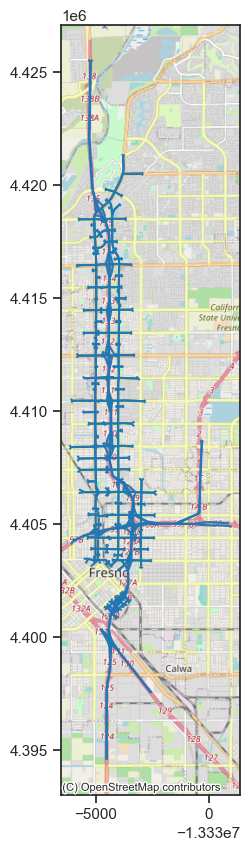

In [10]:
## Display network
fig, ax = plt.subplots(figsize=(10, 10))
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
links_gdf.to_crs(epsg=3857).plot(ax = ax)
ctx.add_basemap(ax = ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Read and load OD matrix

In [11]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read and load paths

In [12]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')
# read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

20840 paths were read and incidence matrices were built


## Read and process spatio-temporal link-level data

In [13]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')

# Select data from Tuesdays to Thursdays
df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]

# # Select data from first Tuesdays of 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

# # Select countdata from selected links
# selected_links = [(290,169,'0'),(170,168,'0'),(337,692,'0'),(228,192,'0'),(191,171,'0'),(188,87,'0'), (171,290,'0'),(192,191,'0'),(87,228,'0'),(169,332,'0'),(631,635,'0'),(179,183,'0'), (641,86,'0'),(638,634,'0'),(170,207,'0'),(86,189,'0'),(580,142,'0'),(333,332,'0'), (99,43,'0'),(637,639,'0')]
# df.loc[~df.link_key.isin(selected_links),'counts'] = float('nan')

In [14]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [15]:
# Curation of travel time and link flow related features
df = data_curation(df)

In [16]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [17]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

# Set capacity in links considering number of lanes
capacity_links = df.groupby('link_key')['capacity'].mean()
for link in network.links:
    network.links_dict[link.key].performance_function.k = float(capacity_links[capacity_links.index==link.key].iloc[0])

## Process node-level data

In [18]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Exploratory Data Analysis

In [19]:
# Stats by date
print(df.groupby('date')[['speed_sd','speed_avg', 'counts_lane']].mean().assign(total_obs = df.groupby('date')['hour'].count()))

            speed_sd  speed_avg  counts_lane  total_obs
date                                                   
2019-10-01  1.731787  17.175187  1497.588808      36195
2019-10-02  1.760109  17.169768  1476.571607      36195
2019-10-03  1.754288  17.092304  1509.584533      36195
2019-10-08  1.847060  18.165569  1478.300459      36195
2019-10-09  1.917923  18.137042  1481.272743      36195
2019-10-10  1.830232  18.107925  1514.981758      36195
2019-10-15  1.831527  18.114384  1480.838248      36195
2019-10-16  1.823680  18.162625  1486.702565      36195
2019-10-17  1.832219  18.080860  1501.029287      36195
2019-10-22  1.837839  18.175561  1470.843410      36195
2019-10-23  1.864443  18.222690  1478.096704      36195
2019-10-24  1.848827  18.184814  1474.877009      36195
2019-10-29  1.868430  18.167171  1465.606342      36195
2019-10-30  1.816364  18.109232  1490.846582      36195
2019-10-31  1.882446  18.128430  1524.102867      36195
2020-10-01  1.290377  19.579215  1359.944262    

In [20]:
## Link-level attributes in utility function
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [21]:
# Hourly data
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

### Reference O-D matrix and trip generation vectors

In [22]:
q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Adjust historic O-D and historic trip generation
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

## Models

In [23]:
train_results_dfs = {}
val_results_dfs = {}
models = {}
inference_models = {}

# Forecasting

In [25]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_models['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                                reference_g = reference_g, dtype = _DTYPE)
inference_models['tvgodlulpe'].build()

inference_models['tvgodlulpe'].load_weights(model_filepaths['tvgodlulpe'])

### - Model estimated with all data from 2019

In [26]:
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_models['tvgodlulpe'].predict(XT_train,
                                           # period_dict = reference_model.period_dict,
                                           node_data=nodes_df,
                                           loss_metric=_LOSS_METRIC,
                                           pretrain_link_flows = False,
                                           # batch_size= _BATCH_SIZE,
                                           optimizer= _OPTIMIZERS['tvgodlulpe']['equilibrium'],
                                           loss_weights={'equilibrium': 1},
                                           threshold_relative_gap=_RELATIVE_GAP,
                                           epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 15, batch size: 225, threshold relative gap: inf
training set -> timepoints: 225, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.5e+04, avg theta = [-3.707 -3.344  0.    -3.521 -0.41  -4.518], avg rr = 0.90, avg theta fixed effect = -0.0057, loss prop od=0, total trips=[6.21e+04 7.02e+04 6.14e+04 6.02e+04 7.37e+04 7.93e+04 7.69e+04 8.11e+04
 9.04e+04 9.50e+04 9.91e+04 9.51e+04 8.70e+04 7.86e+04 6.80e+04], polynomial weights: [1.8e-01 9.3e-03 9.5e-03], kappa = [123.852  34.391 -42.918], lambda eq=1, relative gap=0.047, train equilibrium loss=1.5e+04, time: 3.6

Relative gap threshold of inf was achieved in equilibrium stage


In [27]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_models['tvgodlulpe'].compute_loss_metrics(
        metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
        X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     17.5  mdape
1   traveltime     4.71  mdape
2  equilibrium     4.63  mdape
0         flow 9.45e+05    mse
1   traveltime  0.00287    mse
2  equilibrium 1.48e+04    mse
0         flow     51.4   mape
1   traveltime     7.35   mape
2  equilibrium 7.65e+09   mape
0         flow    0.771     r2
1   traveltime    0.959     r2
2  equilibrium    0.993     r2


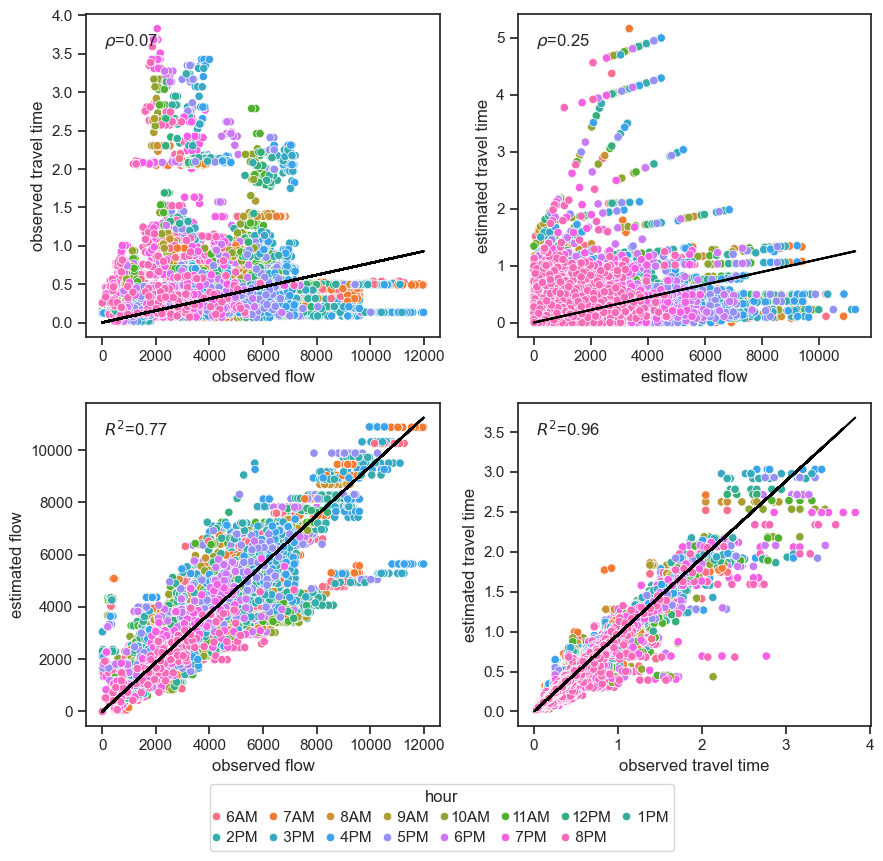

In [28]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvgodlulpe'],
                        observed_traveltime=inference_models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe-2019.png', dpi = 300, bbox_inches='tight')
plt.show()

### -Make prediction on 2020, the validation set

In [29]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_models['tvgodlulpe-2020'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                                reference_g = reference_g, dtype = _DTYPE)
inference_models['tvgodlulpe-2020'].build()

inference_models['tvgodlulpe-2020'].load_weights(model_filepaths['tvgodlulpe'])

In [30]:
_ = inference_models['tvgodlulpe-2020'].predict(XT_val,
                                           node_data=nodes_df,
                                           loss_metric=_LOSS_METRIC,
                                           # batch_size= _BATCH_SIZE,
                                           optimizer= _OPTIMIZERS['tvgodlulpe']['equilibrium'],
                                           pretrain_link_flows = False,
                                           loss_weights={'equilibrium': 1},
                                           threshold_relative_gap= inference_models['tvgodlulpe'].compute_relative_gap(),
                                           epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 15, batch size: 195, threshold relative gap: 0.04702413082122803
training set -> timepoints: 195, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=3.8e+04, avg theta = [-3.707 -3.344  0.    -3.521 -0.41  -4.518], avg rr = 0.90, avg theta fixed effect = -0.0057, loss prop od=0, total trips=[6.21e+04 7.02e+04 6.14e+04 6.02e+04 7.37e+04 7.93e+04 7.69e+04 8.11e+04
 9.04e+04 9.50e+04 9.91e+04 9.51e+04 8.70e+04 7.86e+04 6.80e+04], polynomial weights: [1.8e-01 9.3e-03 9.5e-03], kappa = [123.852  34.391 -42.918], lambda eq=1, relative gap=0.063, train equilibrium loss=3.8e+04, time: 2.4

1/100: train mse=3.8e+04, avg theta = [-3.707 -3.344  0.    -3.521 -0.41  -4.518], avg rr = 0.90, avg theta fixed effect = -0.0057, loss prop od=0, total trips=[6.21e+04 7.02e+04 6.14e+04 6.02e+04 7.37e+04 7.93e+04 7.69e+04 8.11e+04
 9.04e+04 9.50e+04 9.91e+04 9.51e+04 8.70e+04 7.86

In [31]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_models['tvgodlulpe'].compute_loss_metrics(
        metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
        X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     21.9  mdape
1   traveltime      6.8  mdape
2  equilibrium     5.26  mdape
0         flow 1.28e+06    mse
1   traveltime  0.00475    mse
2  equilibrium 3.84e+04    mse
0         flow     39.1   mape
1   traveltime     10.6   mape
2  equilibrium 2.88e+16   mape
0         flow    0.634     r2
1   traveltime    0.926     r2
2  equilibrium    0.982     r2


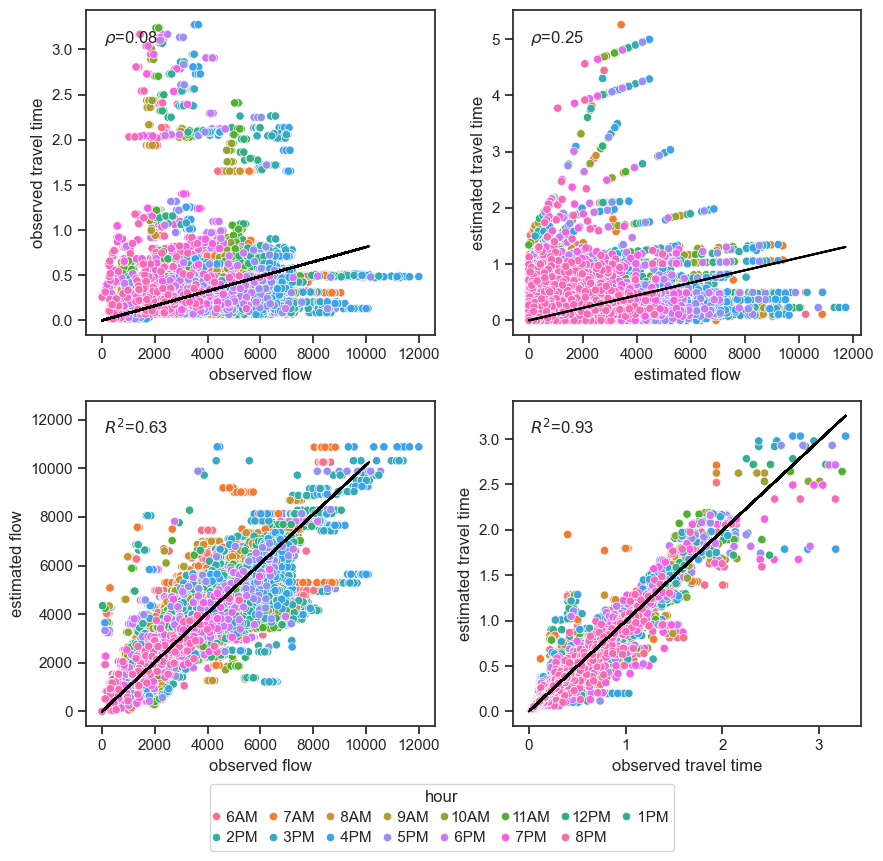

In [32]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvgodlulpe'],
                        observed_traveltime=inference_models['tvgodlulpe'].mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_models['tvgodlulpe'].mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe-2020.png', dpi = 300, bbox_inches='tight')
plt.show()

## K-Fold Cross Validation

In [32]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}

In [33]:
models_kfold['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z, reference_g = reference_g)
models_kfold['tvgodlulpe'].build()

# # Use pretrained weights
# models_kfold['tvgodlulpe'].load_weights(model_filepaths['tvgodlulpe'])
# models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

# Assumed there is access to reference OD matrix
# q_reference = models_kfold['tvgodlulpe'].q

# Add historic OD from estimation in 2019
# models_kfold['tvgodlulpe'].od.reference_values = q_reference

In [34]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS ,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= _OPTIMIZERS['tvgodlulpe'],
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD['tvgodlulpe'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    # epochs_print_interval= _EPOCHS['tvgodlulpe'].copy(),
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS['tvgodlulpe'],
)

2023-12-21 22:59:50.215986: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Fold 1/5

Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 6 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 7 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 8 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 9 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 10 -> p-values kappa: {'population': 0.0017,

In [35]:
filename = f"{ts}_kfold_{network.key}.csv"
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{filename}")
print(f"File {filename} written with k-fold results for TVGODULPE model")

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

File 231221225804_kfold_fresno.csv written with k-fold results for TVGODULPE model
                                               median     mean      std
dataset    component  metric stage                                     
training   flow       mape   final               30.7     29.2     3.86
                             historical mean     89.7     90.5     6.59
                             initial             59.6     60.7     1.94
                      mdape  final               16.4     15.6     1.51
                             historical mean     38.2     38.6     1.72
                             initial             52.2     51.6     1.81
                      mse    final           6.81e+05 7.21e+05 7.67e+04
                             historical mean 3.58e+06  3.5e+06  2.1e+05
                             initial         5.54e+06 5.57e+06 2.26e+05
                      r2     final              0.812    0.793   0.0344
                             historical mean 1.57e-09

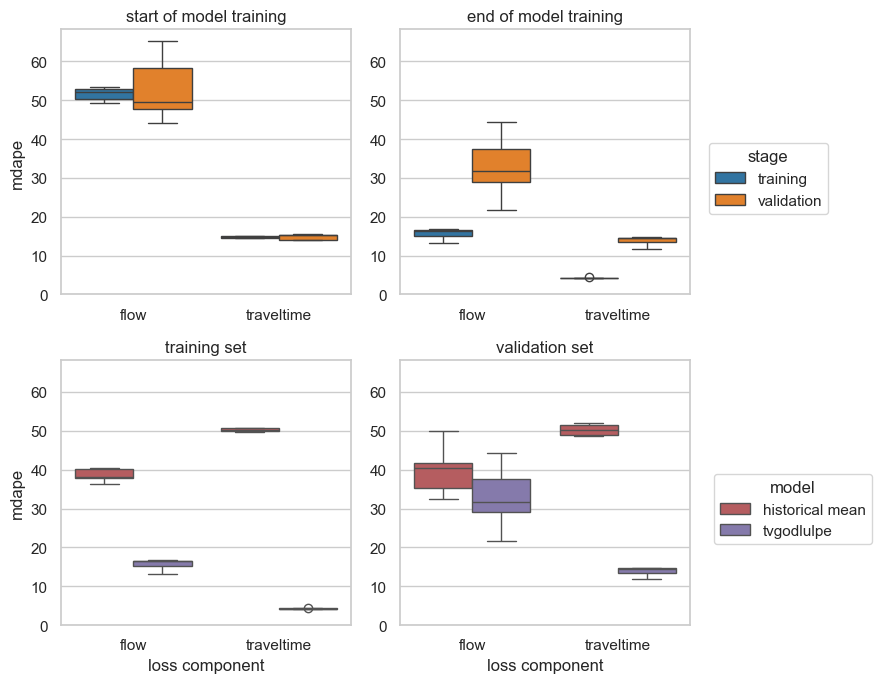

In [49]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], model_name = 'tvgodlulpe', metric_name = _EVALUATION_METRIC.__name__, showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png', dpi = 300)

plt.show()

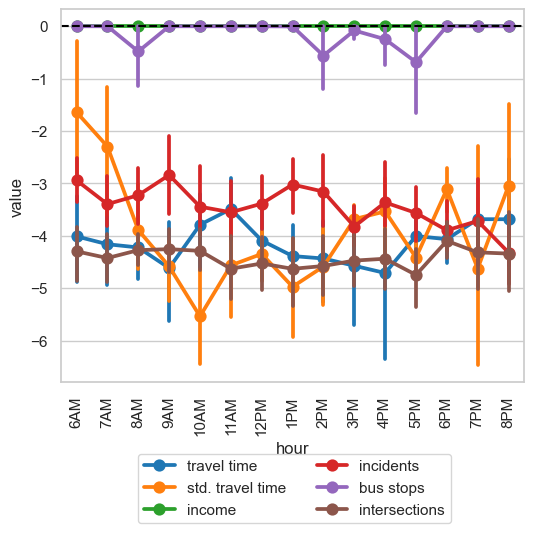

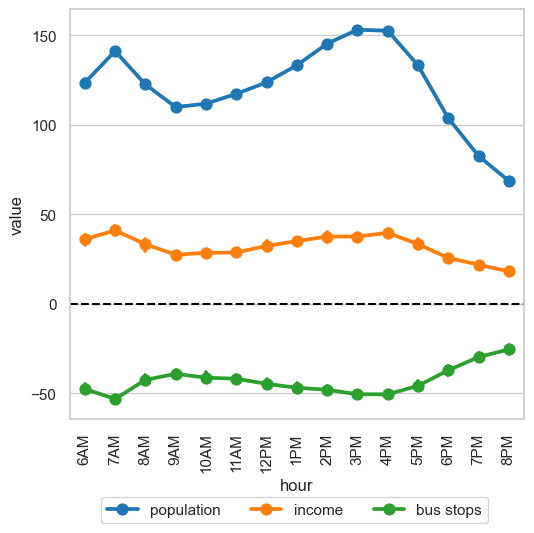

In [37]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True, rotation_xticks=90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png', dpi = 300)

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True, rotation_xticks=90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png', dpi = 300)

plt.show()

### - Baselines

In [38]:
# Calculate centroids of links to compute baselines models
links_gdf['X'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).x
links_gdf['Y'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).y
coordinates = links_gdf[['X', 'Y']].values

In [39]:
# Baselines are computed for every sample
metrics_kfold_df['baselines'] = pd.DataFrame({})
n_samples = XT_val.shape[0]

t0 = time.time()
for i in range(n_samples):

    isl.printer.printIterationBar(i+1, n_samples, prefix='Sample:',length=20)

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,0][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'traveltime')])

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,1][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'flow')])

    metrics_kfold_df['baselines']['sample'] = i

print(f'runtime: {time.time()-t0:0.1f} [s]')

Sample: |####################| 195/195 
runtime: 458.8 [s]


In [40]:
metrics_kfold_df['baselines'].to_csv(f"./output/experiments/{ts}_kfold_baselines_{network.key}.csv")

### Comparison between our model and benchmarks

In [41]:
metrics_kfold_plot_df = metrics_kfold_df['tvgodlulpe'][
        (metrics_kfold_df['tvgodlulpe'].component != 'equilibrium') & (metrics_kfold_df['tvgodlulpe'].metric == _EVALUATION_METRIC.__name__) &
        (metrics_kfold_df['tvgodlulpe'].dataset == 'validation') & (metrics_kfold_df['tvgodlulpe'].stage == 'final')].\
        assign(model = 'tvgodlulpe')

In [42]:
metrics_kfold_df['baselines'] \
    = metrics_kfold_df['baselines'].groupby(['fold', 'model', 'component'])[['value']].mean().reset_index()

metrics_kfold_plot_df = pd.concat([metrics_kfold_df['baselines'][['model','component','value']],
                                   metrics_kfold_plot_df[['model','component','value']]])

In [43]:
means_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].mean().reset_index().rename(columns={'value':'mean'})
se_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].agg(['std', 'count']).apply(lambda row: row['std'] / np.sqrt(row['count']), axis=1).reset_index().rename(columns={0:'se'})

pd.merge(means_mapes, se_mapes).sort_values(by = ['component', 'mean'])

,component,model,mean,se
4,flow,tvgodlulpe,3.290221e+01,3.838705e+00
3,flow,ordinary_kriging,3.469621e+01,1.205453e+00
0,flow,historical_mean,3.478421e+01,1.235485e+00
1,flow,kriging_regression,3.575739e+01,2.684760e+00
2,flow,linear_regression,3.779993e+01,1.315640e+00
9,traveltime,tvgodlulpe,1.379850e+01,5.403807e-01
6,traveltime,kriging_regression,2.502752e+01,4.268098e-01
5,traveltime,historical_mean,3.983391e+01,6.525342e-01
7,traveltime,linear_regression,4.022668e+01,6.611709e-01
8,traveltime,ordinary_kriging,3.038313e+16,2.994081e+16


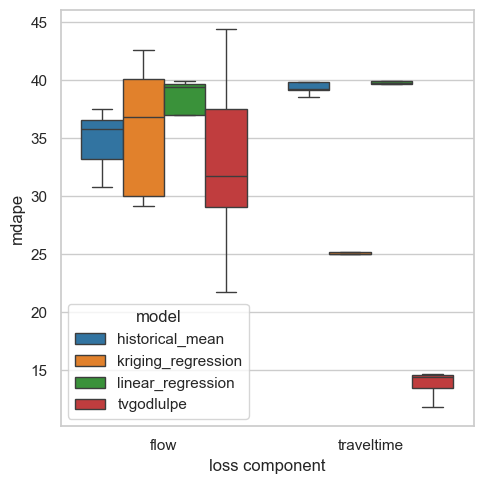

In [59]:
# Note: Result from ordinary kriging are removed due to unstable estimates and extremely large values of evaluation metric for travel time
plot_baselines_kfold(df = metrics_kfold_plot_df[metrics_kfold_plot_df.model != 'ordinary_kriging'],
                     metric_name=_EVALUATION_METRIC.__name__, sharex=True, sharey=True, showfliers = False)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-baselines-tvgodlulpe.png', dpi=300)

### Predicted traffic congestion

In [45]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin(_HOURS)) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=inference_models['tvgodlulpe'], model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis', benchmark_model = 'regression_kriging')

/Users/pablo/miniforge3/envs/nesuelogit/lib/python3.10/site-packages/mapclassify/classifiers.py:939: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Users/pablo/miniforge3/envs/nesuelogit/lib/python3.10/site-packages/mapclassify/classifiers.py:969: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


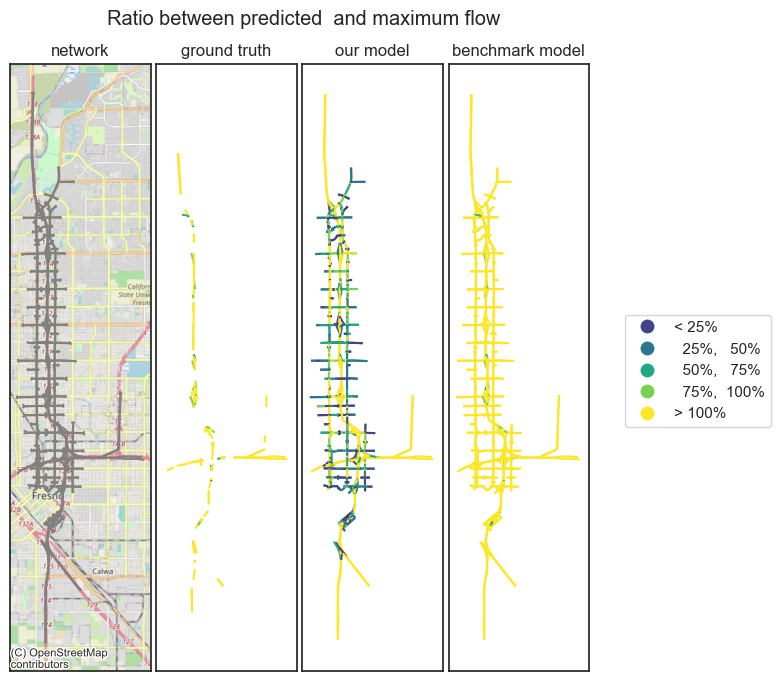

In [46]:
fig_flow.savefig('output/figures/results/fresno-map-flow-tvgodlulpe.png', dpi=300)
fig_flow

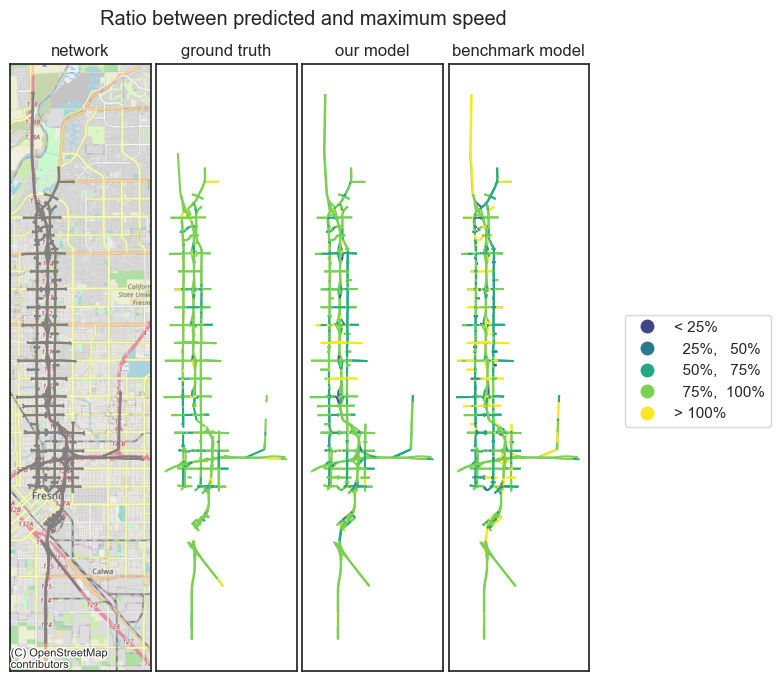

In [47]:
fig_speed.savefig('output/figures/results/fresno-map-speed-tvgodlulpe.png', dpi=300)
fig_speed



## Global runtime

In [48]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 37255.4 [s]
